Vehicle Detection and Tracking
===


## The goal is to write a software pipeline to identify vehicles in a video from a front-facing camera on a car.

## The steps which were taken to accomplish this project are the following:

1. Perform Histogram of Oriented Gradients (HOG) feature extraction, binned color feature extraction and color histogram feature extraction on a labeled training set of images
2. Setup and train a Linear SVM classifier
3. Implement sliding-window technique with multi-scale windows and use the trained classifier to search for vehicles in images.
4. Implement hog sub-sampling window search technique to speed up the vehicle detection process; Apply a heat-map from vehicle detections to combine overlapping detections and remove false positives.
5. Modify the parameters and run the pipeline on the project_video stream to estimate a bounding box for vehicles detected.

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from scipy.ndimage.measurements import label
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
%matplotlib inline


### 1.  Feature extraction

In [2]:
# Define a function to return HOG features
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    bin_features=np.hstack((color1, color2, color3))
    return bin_features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [3]:
# Define a fuction to extract features from a feature image
def feature_image_ext(feature_image,orient, pix_per_cell, cell_per_block, hog_channel,spatial_size,
                  hist_bins, hist_range,spatial_feat, hist_feat, hog_feat):
    
    features_temp=[]
    
    if spatial_feat==True:
            # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        features_temp.append(spatial_features)

    if hist_feat==True:
            # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        features_temp.append(hist_features)
    
    if hog_feat == True:
    # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))  
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)

        features_temp.append(hog_features)

            
    return features_temp


In [4]:
# Define a function to extract features from a list of images
def extract_features(imgs,color_space, orient, pix_per_cell, cell_per_block, hog_channel,spatial_size,
                     hist_bins, hist_range,spatial_feat, hist_feat, hog_feat):
    # Create a list to append feature vectors
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one,only for png files
        image = cv2.imread(file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #image = image*255 
        #image.astype(int)
        features_temp=[]
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)   
        
        features_temp=feature_image_ext(feature_image,orient, pix_per_cell, cell_per_block, hog_channel,spatial_size,
                        hist_bins, hist_range,spatial_feat=True, hist_feat=True, hog_feat=True)
        
        features.append(np.concatenate(features_temp))
        
        feature_image=cv2.flip(feature_image,1)
        features_temp=feature_image_ext(feature_image,orient, pix_per_cell, cell_per_block, hog_channel,spatial_size,
                        hist_bins, hist_range,spatial_feat=True, hist_feat=True, hog_feat=True)
        
        # Append the new feature vector to the features list
        features.append(np.concatenate(features_temp))

    # Return list of feature vectors
    return features


In [5]:
# Training and validation Data Preparation (features and labels)

# Read in example images and divide up into cars and notcars
images = glob.glob('*vehicles/*/*')
cars = []
noncars = []
for image in images:
    if 'non' in image:
        noncars.append(image)
    else:
        cars.append(image)
        
print('Numbers of car examples:',len(cars))
print('Numbers of noncar examples:',len(noncars))        

# Parameter Sets
# HOG feature extraction parameters
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

# bin_spatial and color_hist feature extraction parameters
spatial = 32
spatial_size=(16, 16)
hist_bins = 32
hist_range=(0, 256)

# Feature extraction method selection
spatial_feat=True
hist_feat=True
hog_feat=True


# Features extraction
t=time.time()
car_features = extract_features(cars,color_space, orient, pix_per_cell, cell_per_block, hog_channel,spatial_size,
                        hist_bins, hist_range,spatial_feat, hist_feat, hog_feat)

noncar_features = extract_features(noncars,color_space, orient, pix_per_cell, cell_per_block, hog_channel,spatial_size,
                        hist_bins, hist_range,spatial_feat, hist_feat, hog_feat)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')


# Feature Normalization 
# Create an array stack of feature vectors
X = np.vstack((car_features, noncar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print(len(X_train))

Numbers of car examples: 8792
Numbers of noncar examples: 8968
186.19 Seconds to extract HOG features...
28416


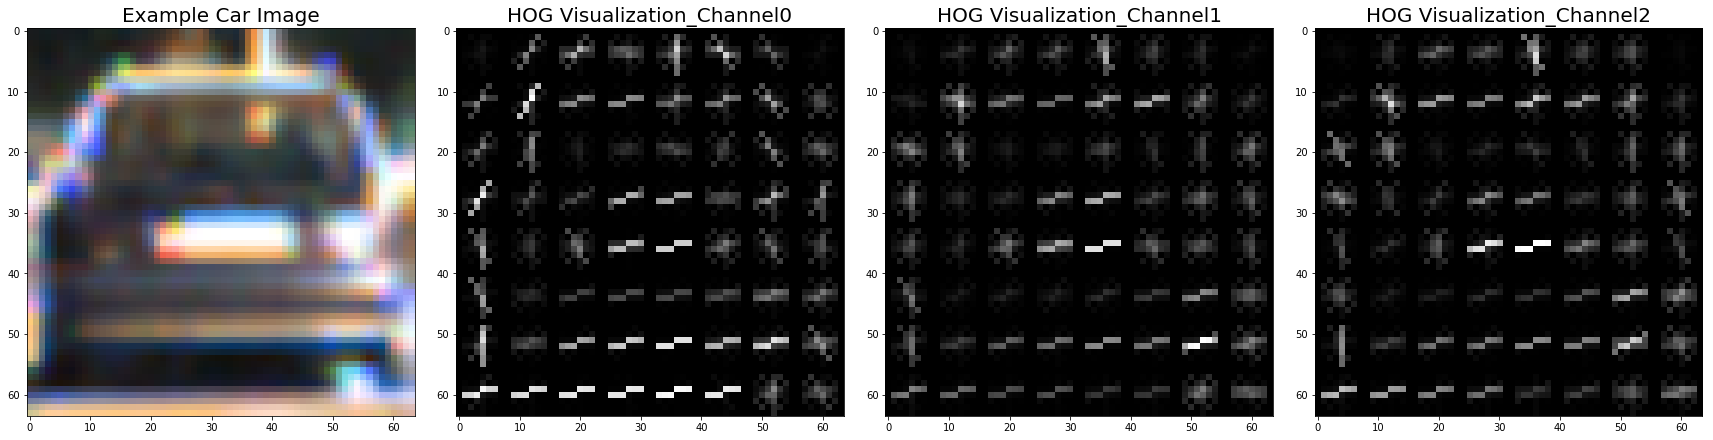

In [6]:
# Test HOG feature extraction with one radom car image

# Define HOG parameters
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2

# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

if color_space != 'RGB':
    if color_space == 'HSV':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    elif color_space == 'LUV':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
    elif color_space == 'HLS':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    elif color_space == 'YUV':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    elif color_space == 'YCrCb':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image) 


# Call our function with vis=True to see an image output
features, hog_image_0 = get_hog_features(feature_image[:,:,0], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)
features, hog_image_1 = get_hog_features(feature_image[:,:,1], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)
features, hog_image_2 = get_hog_features(feature_image[:,:,2], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)


# Visualization
f, (ax1, ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Example Car Image', fontsize=20)
ax2.imshow(hog_image_0,cmap='gray')
ax2.set_title('HOG Visualization_Channel0', fontsize=20)
ax3.imshow(hog_image_1,cmap='gray')
ax3.set_title('HOG Visualization_Channel1', fontsize=20)
ax4.imshow(hog_image_2,cmap='gray')
ax4.set_title('HOG Visualization_Channel2', fontsize=20)


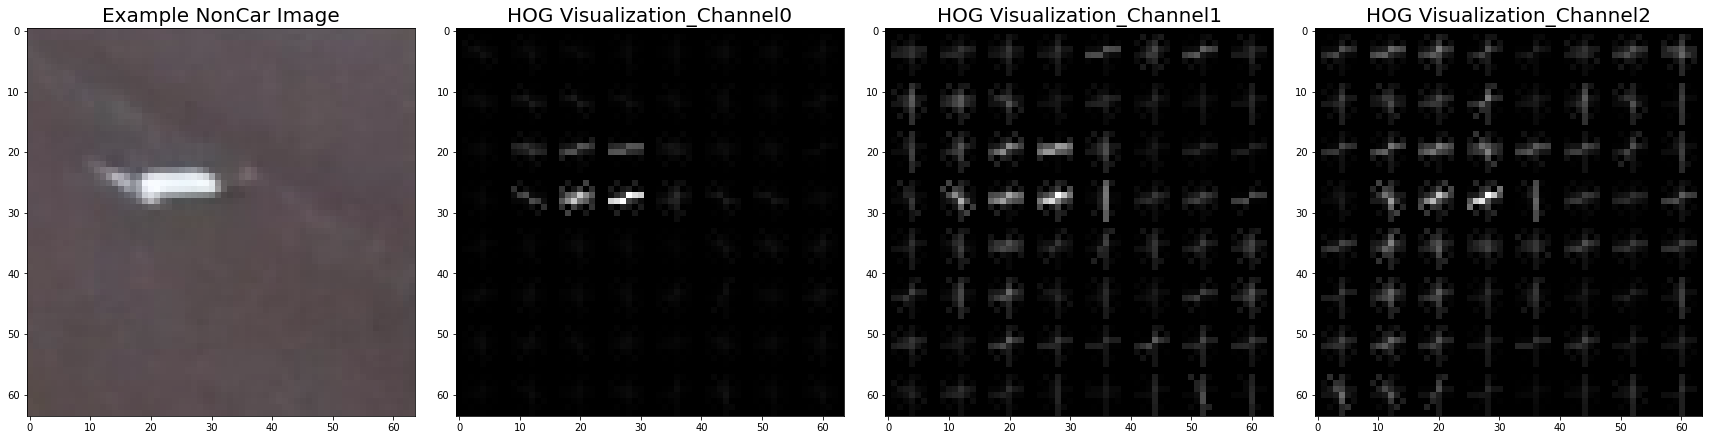

In [7]:
# Test HOG feature extraction with one radom noncar image

# Generate a random index to look at a car image
ind = np.random.randint(0, len(noncars))
# Read in the image
image = mpimg.imread(noncars[ind])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

if color_space != 'RGB':
    if color_space == 'HSV':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    elif color_space == 'LUV':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
    elif color_space == 'HLS':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    elif color_space == 'YUV':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    elif color_space == 'YCrCb':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image) 


# Call our function with vis=True to see an image output
features, hog_image_0 = get_hog_features(feature_image[:,:,0], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)
features, hog_image_1 = get_hog_features(feature_image[:,:,1], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)
features, hog_image_2 = get_hog_features(feature_image[:,:,2], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)


# Visualization
f, (ax1, ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Example NonCar Image', fontsize=20)
ax2.imshow(hog_image_0,cmap='gray')
ax2.set_title('HOG Visualization_Channel0', fontsize=20)
ax3.imshow(hog_image_1,cmap='gray')
ax3.set_title('HOG Visualization_Channel1', fontsize=20)
ax4.imshow(hog_image_2,cmap='gray')
ax4.set_title('HOG Visualization_Channel2', fontsize=20)

## 2. Classifier Trainning

In [8]:
# SVM Classifier Trainning
# Use a linear SVC 
clf = LinearSVC()
# Check the training time for the SVC
t=time.time()
clf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
Test_accuracy=clf.score(X_test, y_test)
print('Test Accuracy of SVC = ', round(Test_accuracy, 4))


30.74 Seconds to train SVC...
Test Accuracy of SVC =  0.9916


## 3. Search for vehicles in images use slide windows

In [9]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
   
        #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)
    #9) Return concatenated array of features
    return np.concatenate(img_features)


In [10]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [11]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space, 
                    spatial_size, hist_bins, 
                    hist_range, orient, 
                    pix_per_cell, cell_per_block, 
                    hog_channel, spatial_feat, 
                    hist_feat, hog_feat):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    

In [12]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

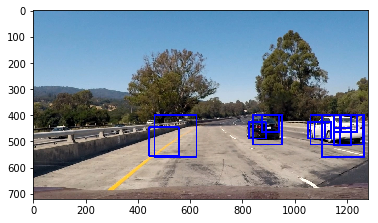

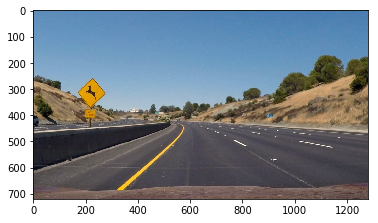

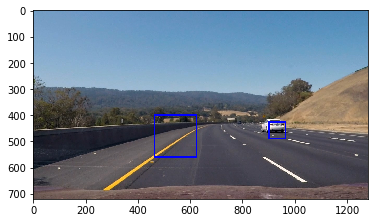

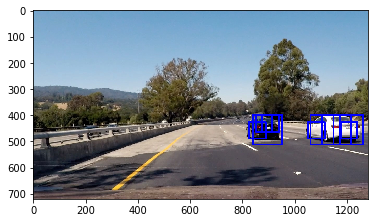

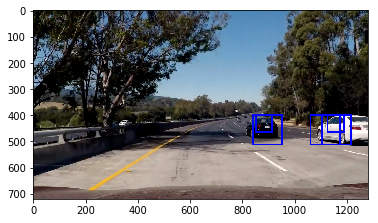

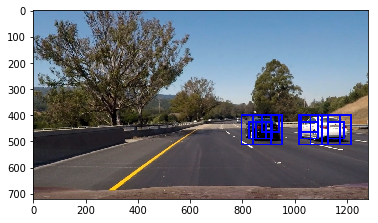

In [13]:
# test in classifier with test images
images = glob.glob('test_images/*.jpg')
for file in images:
    image = mpimg.imread(file)
    #image = image.astype(np.float32)/255 
    #image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    draw_image = np.copy(image)
    x_start_stop=[400, 1280]
    y_start_stop=[400, 600]
    
    window_range=range(64,208,48)
    xy_overlap=(0.6, 0.6)
    windows=[]
    for i in range(len(window_range)):
        xy_window=(window_range[i],window_range[i])
        windows.extend(slide_window(image, x_start_stop, y_start_stop, 
                        xy_window, xy_overlap))

    hot_windows=[]
    hot_windows = search_windows(image, windows, clf, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins,hist_range=hist_range,
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)    


    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6) 
    
    plt.figure()
    plt.imshow(window_img)
    
    

## 4. Efficient search car method 

### 4.1 Define functions

In [14]:
# define covert color function

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

In [15]:

# Define a single function that can extract features using hog sub-sampling and make predictions
#def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,cells_per_step):
def find_cars(img, ystart, ystop, xstart,xstop,scale, svc, cells_per_step):
    
    out_img = np.copy(img)
    #img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window=64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    #  cells_per_step  Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    box_list=[]
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            if hog_channel == 'ALL': 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            elif hog_channel == 0: 
                hog_features = hog_feat1
            elif hog_channel == 1:
                hog_features = hog_feat2
            elif hog_channel == 2:
                hog_features = hog_feat3
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)+xstart
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(out_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                box_list.append(((int(xbox_left), int(ytop_draw+ystart)),(int(xbox_left+win_draw),int(ytop_draw+win_draw+ystart))))
    
    return out_img,box_list
    


In [16]:
# Define function for multiple detection and false positives handling
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


### 4.2 Test with one set of parameters

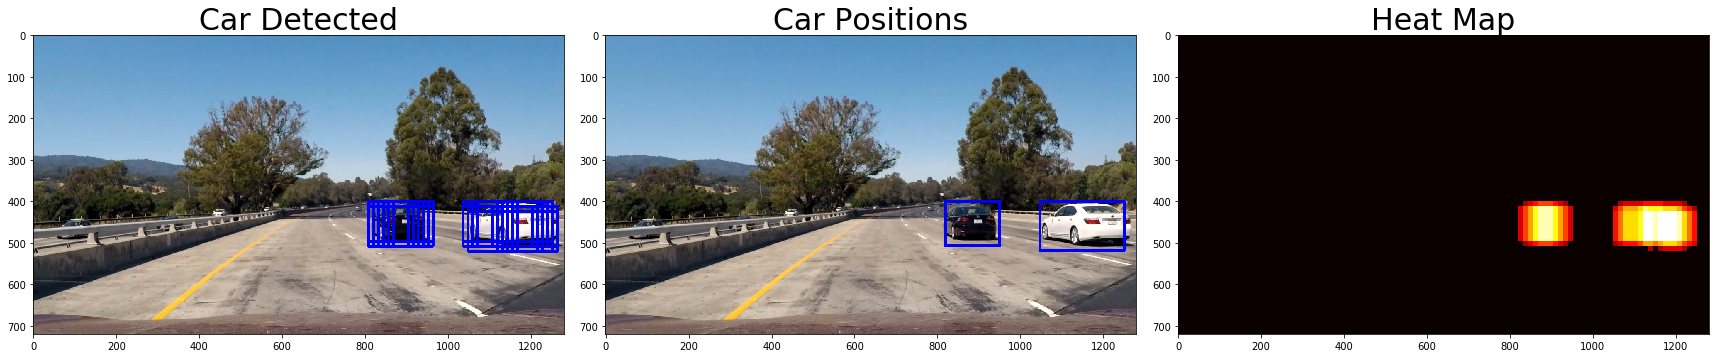

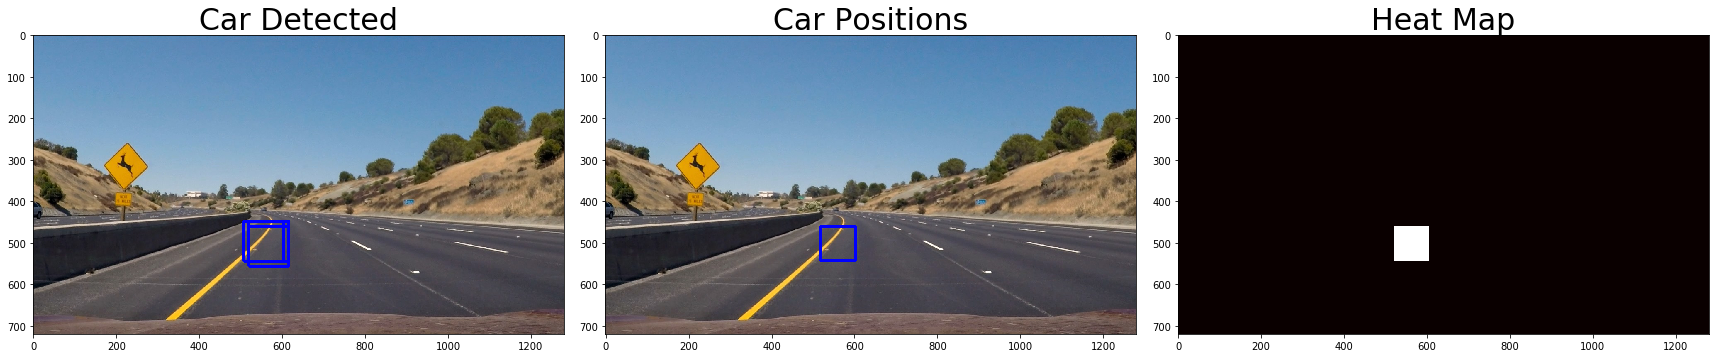

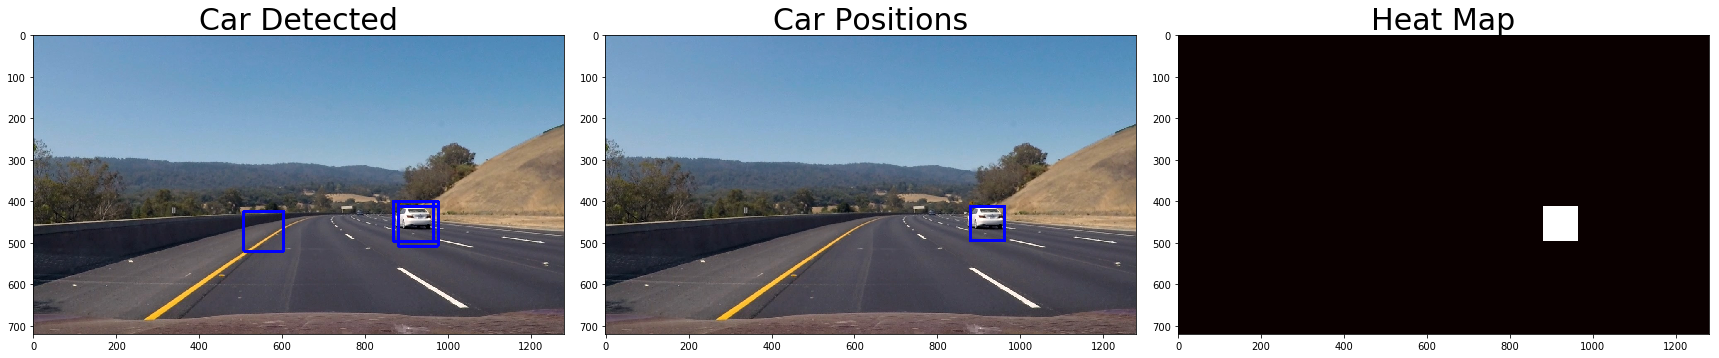

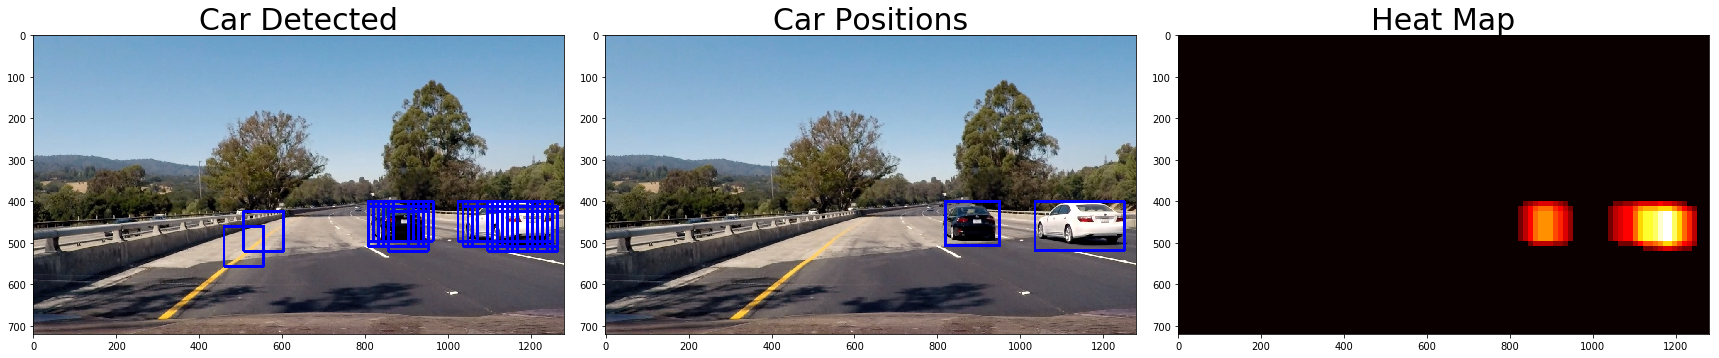

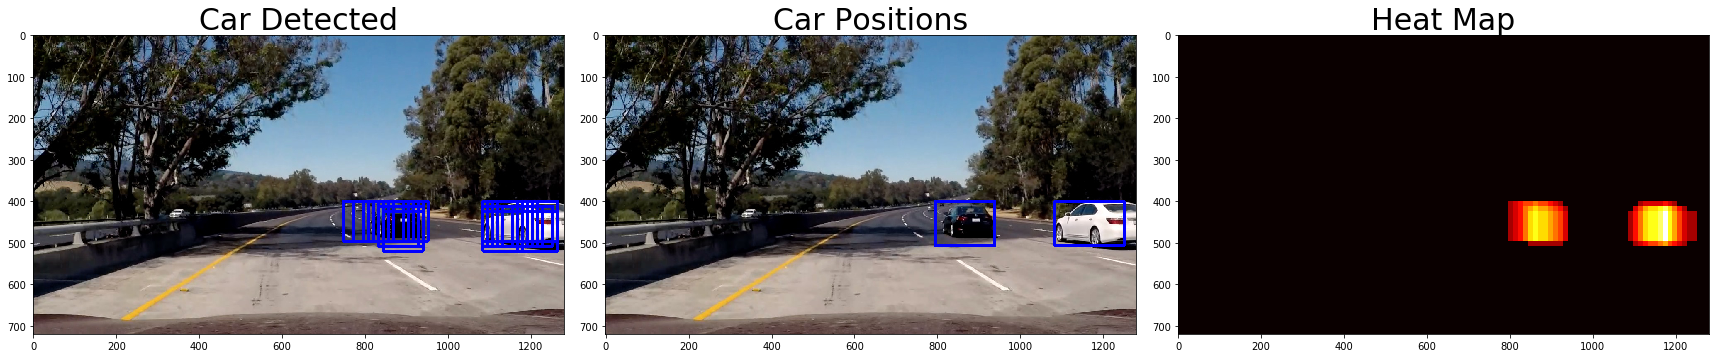

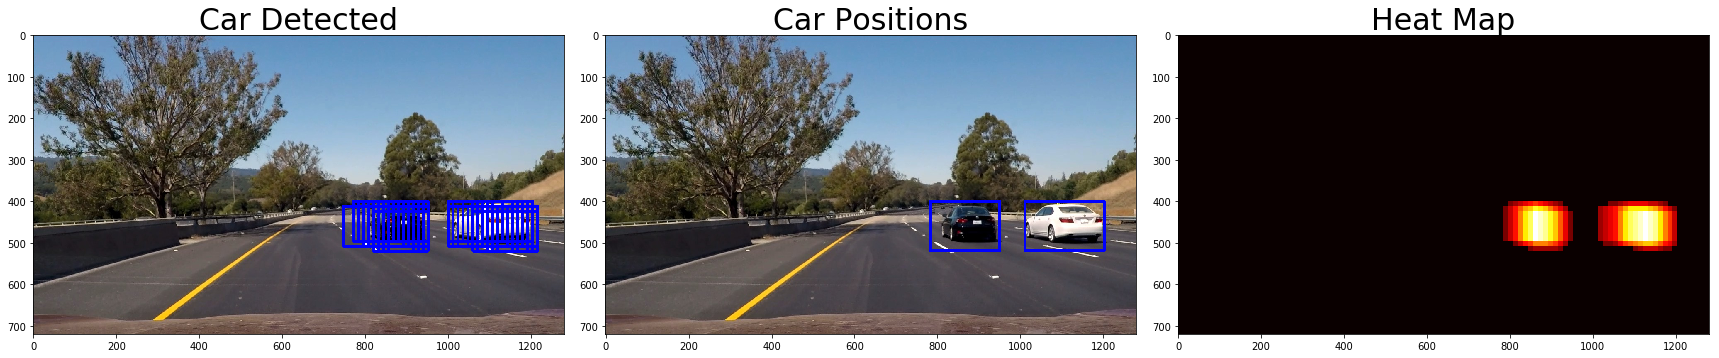

In [17]:
# parameter setting 
ystart = y_start_stop[0]
ystop = y_start_stop[1]
xstart=400
xstop=1280

scale = 1.5
cells_per_step=1


images = glob.glob('test_images/*.jpg')

for file in images:
    img = mpimg.imread(file)
    out_img,box_list = find_cars(img, ystart, ystop, xstart,xstop,scale, clf,cells_per_step)
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    # Visualization
    f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(out_img)
    ax1.set_title('Car Detected', fontsize=30)
    ax2.imshow(draw_img)
    ax2.set_title('Car Positions', fontsize=30)
    ax3.imshow(heatmap, cmap='hot')
    ax3.set_title('Heat Map', fontsize=30)


### 4.3 Define and test a function to find cars with multiple-scaled search windows 

In [18]:
# define multiple scaled search function

def vehicle_detection(img):

    global heat_last
    
    out_img_1,box_list_1 = find_cars(img, ystart_1, ystop_1, xstart_1,xstop_1, scale_1, clf, cells_per_step_1)
    out_img_2,box_list_2 = find_cars(img, ystart_2, ystop_2, xstart_2,xstop_2,scale_2, clf, cells_per_step_2)
    out_img_3,box_list_3 = find_cars(img, ystart_3, ystop_3, xstart_3,xstop_3,scale_3, clf, cells_per_step_3)
    out_img_4,box_list_4 = find_cars(img, ystart_4, ystop_4, xstart_4,xstop_4,scale_4, clf, cells_per_step_4)
    
    box_list=box_list_1+box_list_2+box_list_3+box_list_4
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,box_list)
    
    if filter_switch==True:
        heat=heat_last*filter_co+heat*(1-filter_co)
        heat_last=heat
        

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    #print(len(np.nonzero(labels[0])[1]))

    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    # Visualization
    #result = plt.imshow(draw_img)
    
    return draw_img
    
    

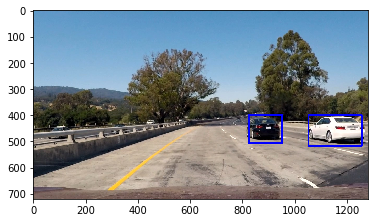

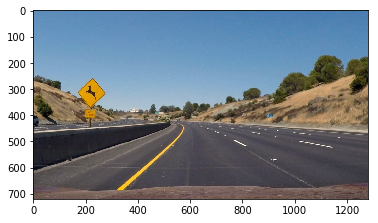

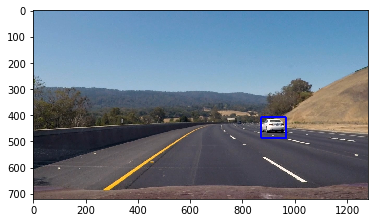

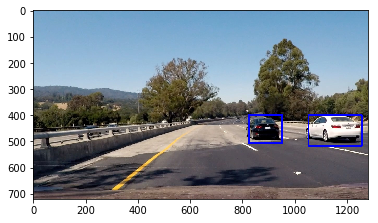

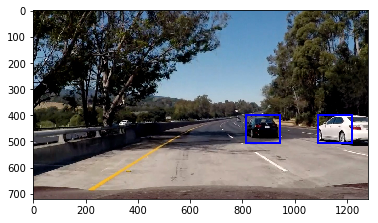

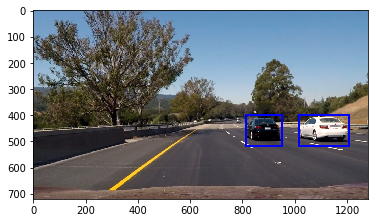

In [19]:
# Test with test images
# parameter sets


ystart_1=400
ystop_1=500
xstart_1=600
xstop_1=1000
scale_1=1
cells_per_step_1=1

ystart_2=500
ystop_2=650
xstart_2=600
xstop_2=800
scale_2=2
cells_per_step_2=3

ystart_3=400
ystop_3=650
xstart_3=400
xstop_3=600
scale_3=2
cells_per_step_3=3

ystart_4=400
ystop_4=650
xstart_4=800
xstop_4=1280
scale_4=1.5
cells_per_step_4=1

threshold=3
filter_switch=False
filter_co=0.4
heat_last = np.zeros((720, 1280)) 

images = glob.glob('test_images/*.jpg')
labels_last=None
for file in images:
    img = mpimg.imread(file)
    output=vehicle_detection(img)
    plt.figure()
    plt.imshow(output)
    

## 5. Vehicle detection in project video

In [20]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
# set filter on for video
filter_switch=True
filter_co=0.4
threshold=3
heat_last = np.zeros((720, 1280)) 

white_output = 'output_images/vehicle_detection_result.mp4'
#clip1 = VideoFileClip("test_video.mp4")
clip1 = VideoFileClip("project_video.mp4")

white_clip = clip1.fl_image(vehicle_detection) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_images/vehicle_detection_result.mp4
[MoviePy] Writing video output_images/vehicle_detection_result.mp4


100%|█████████▉| 1260/1261 [10:37<00:00,  2.04it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/vehicle_detection_result.mp4 

CPU times: user 10min 1s, sys: 33.1 s, total: 10min 34s
Wall time: 10min 38s
